In [158]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Carbon Pricing and Emissions: Does it Actually Work?

## What I'm Trying to Find Out

My research question is: Do carbon pricing policies actually reduce CO₂ emissions? 
I'm looking at data from different countries and regions from 2000-2024 to see if 
places with higher carbon prices have lower emissions.

## My Hypothesis

Jurisdictions with higher carbon prices will have lower emissions (or slower emissions 
growth) compared to those with lower prices.

## Why This Matters

Carbon pricing is one of the main tools governments use to fight climate change. But 
there's a lot of debate about whether it actually works. This analysis will help show 
if the evidence supports using carbon pricing as a climate policy.

## What I'll Do

I'll use statistical analysis to compare carbon prices and emissions across different 
jurisdictions. I'll look at correlations, run regressions, and compare high-price vs 
low-price regions.

In [175]:
BOLD = '\033[1m'
END = '\033[0m'

prices = pd.read_csv('data/compliance_price.csv')
emissions = pd.read_csv('data/compliance_emissions.csv')
weighted_prices = pd.read_csv('data/emissions-weighted-carbon-price.csv')

print("Datasets:")
print(f"  Price data: {prices.shape[0]} rows, {prices.shape[1]} columns")
print(f"  Emissions data: {emissions.shape[0]} rows, {emissions.shape[1]} columns")
print(f"  Weighted prices: {weighted_prices.shape[0]} rows, {weighted_prices.shape[1]} columns")

Datasets:
  Price data: 80 rows, 42 columns
  Emissions data: 91 rows, 37 columns
  Weighted prices: 7272 rows, 4 columns


In [161]:
print(f"{BOLD}Data Quality Checks{END}")

year_cols = [str(y) for y in range(2000, 2025)]

print(f"{BOLD}\nMissing Data{END}")
price_missing = prices[year_cols].isna().sum().sum()
emissions_missing = emissions[year_cols].isna().sum().sum()
total_price_cells = prices[year_cols].size
total_emission_cells = emissions[year_cols].size

print(f"\nPrice data:")
print(f"  Missing values: {price_missing} out of {total_price_cells}")
print(f"  Percent missing: {price_missing/total_price_cells*100:.1f}%")

print(f"\nEmissions data:")
print(f"  Missing values: {emissions_missing} out of {total_emission_cells}")
print(f"  Percent missing: {emissions_missing/total_emission_cells*100:.1f}%")

print(f"\n{BOLD}Duplicate entries:{END}")
print(f"  Price data: {prices['Name of the initiative'].duplicated().sum()}")
print(f"  Emissions data: {emissions['Name of the initiative'].duplicated().sum()}")

price_initiatives = set(prices['Name of the initiative'])
emission_initiatives = set(emissions['Name of the initiative'])
both = price_initiatives & emission_initiatives

print(f"\nDataset overlap:")
print(f"  Initiatives in price data: {len(price_initiatives)}")
print(f"  Initiatives in emissions data: {len(emission_initiatives)}")
print(f"  Initiatives in BOTH: {len(both)}")
print(f"  Only in price: {len(price_initiatives - emission_initiatives)}")
print(f"  Only in emissions: {len(emission_initiatives - price_initiatives)}")

Data Quality Checks

Missing Data

Price data:
  Missing values: 1265 out of 2000
  Percent missing: 63.2%

Emissions data:
  Missing values: 0 out of 2275
  Percent missing: 0.0%

Duplicate entries:
  Price data: 0
  Emissions data: 0

Dataset overlap:
  Initiatives in price data: 80
  Initiatives in emissions data: 91
  Initiatives in BOTH: 78
  Only in price: 2
  Only in emissions: 13


## Data Preparation

The raw data is in "wide" format with years as columns. I need to convert it to "long" 
format where each row is one jurisdiction-year observation. This makes it easier to 
analyze.

I'll also merge the price and emissions data together and remove any rows with missing 
or invalid values (like negative prices or zero emissions).

In [164]:
print(f"{BOLD}Cleaning and Merging Data{END}")

# Price Data
price_long = prices.melt(
    id_vars=['Name of the initiative', 'Instrument Type', 'Region', 'Income group'],
    value_vars=year_cols, 
    var_name='Year', 
    value_name='Price'
)
price_long['Year'] = price_long['Year'].astype(int)
price_long['Price'] = pd.to_numeric(price_long['Price'], errors='coerce')

# Emission Data
emission_long = emissions.melt(
    id_vars=['Name of the initiative'],
    value_vars=year_cols, 
    var_name='Year', 
    value_name='Emissions'
)
emission_long['Year'] = emission_long['Year'].astype(int)
emission_long['Emissions'] = pd.to_numeric(emission_long['Emissions'], errors='coerce')

# Combining price and emissions data
df = price_long.merge(emission_long, on=['Name of the initiative', 'Year'], how='inner')

print(f"\nBefore cleaning: {len(df):,} rows")

# Issues
missing_price = df['Price'].isna().sum()
missing_emissions = df['Emissions'].isna().sum()
bad_price = (df['Price'] <= 0).sum()
bad_emissions = (df['Emissions'] <= 0).sum()

print(f"Removing: {missing_price:,} missing prices, {missing_emissions:,} missing emissions,")
print(f"{bad_price:,} invalid prices, {bad_emissions:,} invalid emissions")

# Cleaning the data
df = df.dropna(subset=['Price', 'Emissions'])
df = df[(df['Price'] > 0) & (df['Emissions'] > 0)]

print(f"After cleaning: {len(df):,} rows ({len(df)/len(price_long.merge(emission_long, on=['Name of the initiative', 'Year'], how='inner'))*100:.1f}% kept)")

weighted_prices.columns = ['Country', 'Code', 'Year', 'Weighted_Price']
weighted_prices['Weighted_Price'] = pd.to_numeric(weighted_prices['Weighted_Price'], errors='coerce')

print(f"\n{BOLD}Final Dataset{END}\n")
print(f"Observations: {len(df):,} | Jurisdictions: {df['Name of the initiative'].nunique()} | Years: {df['Year'].min()}-{df['Year'].max()}")

Cleaning and Merging Data

Before cleaning: 1,950 rows
Removing: 1,215 missing prices, 0 missing emissions,
51 invalid prices, 1,197 invalid emissions
After cleaning: 640 rows (32.8% kept)

Final Dataset

Observations: 640 | Jurisdictions: 72 | Years: 2000-2024


In [165]:
print(f"{BOLD}Data Preview{END}")

print(f"\n{BOLD}First 10 rows of combined dataset:{END}")
print(df.head(10).to_string(index=False))

print(f"\n\n{BOLD}Random sample of 5 rows:{END}")
print(df.sample(5).to_string(index=False))

Data Preview

First 10 rows of combined dataset:
Name of the initiative Instrument Type                Region Income group  Year     Price  Emissions
    Finland carbon tax      Carbon tax Europe & Central Asia  High income  2000 16.392948   0.000917
     Norway carbon tax      Carbon tax Europe & Central Asia  High income  2000 85.390339   0.001022
     Poland carbon tax      Carbon tax Europe & Central Asia  High income  2000  0.041870   0.002752
     Sweden carbon tax      Carbon tax Europe & Central Asia  High income  2000 42.675894   0.000836
    Finland carbon tax      Carbon tax Europe & Central Asia  High income  2001 15.155712   0.000984
     Norway carbon tax      Carbon tax Europe & Central Asia  High income  2001 58.975062   0.001030
     Poland carbon tax      Carbon tax Europe & Central Asia  High income  2001  0.036870   0.002690
     Sweden carbon tax      Carbon tax Europe & Central Asia  High income  2001 51.022864   0.000827
    Finland carbon tax      Carbon tax Eur

In [167]:
print(f"{BOLD}Summary Statistics{END}")

print("\nCarbon Price (US$/tCO2e):")
print(df['Price'].describe().round(2))

print("\nEmissions (GtCO2):")
print(df['Emissions'].describe().round(4))

print("\nBreakdown by Policy Type:")
print(df['Instrument Type'].value_counts())
print(f"\nTotal: {df['Instrument Type'].value_counts().sum()}")

print("\nTop Regions:")
print(df['Region'].value_counts().head(8))

print("\nData Coverage:")
coverage = df.groupby('Name of the initiative').size()
print(f"  Average years per jurisdiction: {coverage.mean():.1f}")
print(f"  Jurisdictions with 10+ years: {(coverage >= 10).sum()}")
print(f"  Jurisdictions with 5-9 years: {((coverage >= 5) & (coverage < 10)).sum()}")
print(f"  Jurisdictions with <5 years: {(coverage < 5).sum()}")

Summary Statistics

Carbon Price (US$/tCO2e):
count    640.00
mean      29.51
std       34.79
min        0.01
25%        5.07
50%       17.05
75%       37.81
max      168.83
Name: Price, dtype: float64

Emissions (GtCO2):
count    640.0000
mean       0.0035
std        0.0106
min        0.0000
25%        0.0003
50%        0.0008
75%        0.0023
max        0.1529
Name: Emissions, dtype: float64

Breakdown by Policy Type:
Instrument Type
Carbon tax    392
ETS           248
Name: count, dtype: int64

Total: 640

Top Regions:
Region
Europe & Central Asia        324
East Asia & Pacific          136
North America                128
Latin America & Caribbean     47
Sub-Saharan Africa             5
Name: count, dtype: int64

Data Coverage:
  Average years per jurisdiction: 8.9
  Jurisdictions with 10+ years: 32
  Jurisdictions with 5-9 years: 15
  Jurisdictions with <5 years: 25


## Exploratory Data Analysis

Let's visualize the data to see patterns and trends. I'll look at:
1. How many carbon pricing policies have been adopted over time
2. Price differences between carbon taxes and ETS
3. The relationship between price and emissions
4. How prices and emissions have changed over time

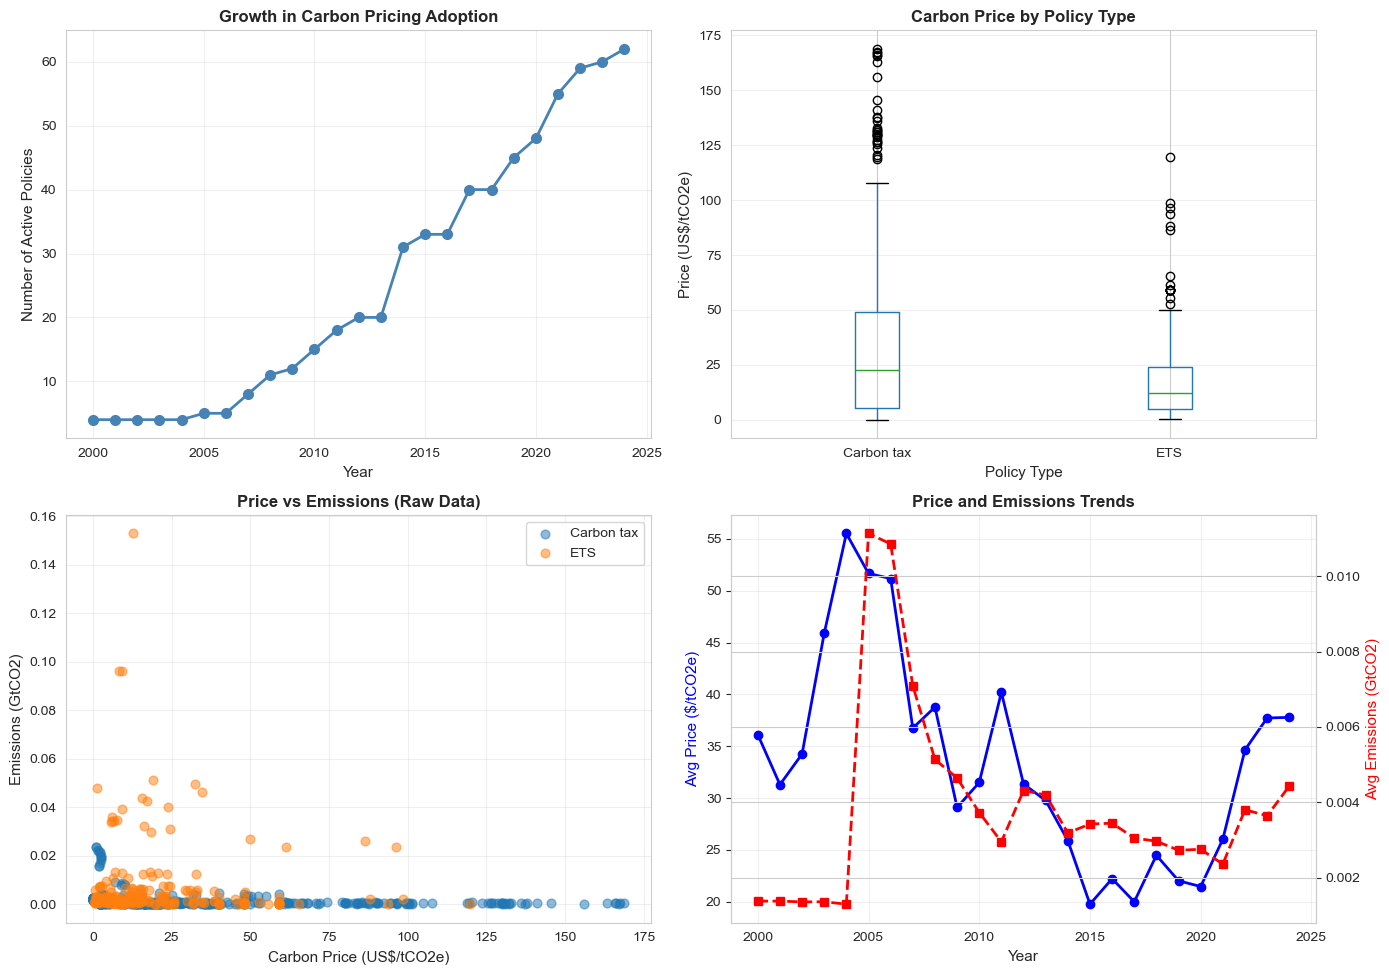


Key Observations:
- Carbon pricing policies grew from 4 in 2000 to 62 in 2024
- ETS systems show more price variation than carbon taxes


In [168]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Number of active policies over time
policy_count = df.groupby('Year')['Name of the initiative'].nunique()
axes[0, 0].plot(policy_count.index, policy_count.values, 'o-', 
                linewidth=2, markersize=7, color='steelblue')
axes[0, 0].set_xlabel('Year', fontsize=11)
axes[0, 0].set_ylabel('Number of Active Policies', fontsize=11)
axes[0, 0].set_title('Growth in Carbon Pricing Adoption', fontweight='bold', fontsize=12)
axes[0, 0].grid(alpha=0.3)

# Plot 2: Price distribution by policy type
df.boxplot(column='Price', by='Instrument Type', ax=axes[0, 1])
axes[0, 1].set_xlabel('Policy Type', fontsize=11)
axes[0, 1].set_ylabel('Price (US$/tCO2e)', fontsize=11)
axes[0, 1].set_title('Carbon Price by Policy Type', fontweight='bold', fontsize=12)
plt.suptitle('')
axes[0, 1].grid(alpha=0.3, axis='y')

# Plot 3: Price vs Emissions scatter
for ptype in df['Instrument Type'].unique():
    data = df[df['Instrument Type'] == ptype]
    axes[1, 0].scatter(data['Price'], data['Emissions'], alpha=0.5, s=40, label=ptype)
axes[1, 0].set_xlabel('Carbon Price (US$/tCO2e)', fontsize=11)
axes[1, 0].set_ylabel('Emissions (GtCO2)', fontsize=11)
axes[1, 0].set_title('Price vs Emissions (Raw Data)', fontweight='bold', fontsize=12)
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Plot 4: Time trends in average price and emissions
yearly = df.groupby('Year').agg({'Price': 'mean', 'Emissions': 'mean'})
ax1 = axes[1, 1]
ax2 = ax1.twinx()
ax1.plot(yearly.index, yearly['Price'], 'b-o', linewidth=2, label='Price')
ax2.plot(yearly.index, yearly['Emissions'], 'r--s', linewidth=2, label='Emissions')
ax1.set_xlabel('Year', fontsize=11)
ax1.set_ylabel('Avg Price ($/tCO2e)', color='b', fontsize=11)
ax2.set_ylabel('Avg Emissions (GtCO2)', color='r', fontsize=11)
ax1.set_title('Price and Emissions Trends', fontweight='bold', fontsize=12)
ax1.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\nKey Observations:")
print(f"- Carbon pricing policies grew from {policy_count.iloc[0]} in {policy_count.index[0]} to {policy_count.iloc[-1]} in {policy_count.index[-1]}")
print(f"- ETS systems show more price variation than carbon taxes")

## Analysis Methods

I'll use three main approaches to analyze the relationship between carbon prices and emissions:

### 1. Correlation Analysis
I'll calculate the Pearson correlation coefficient to see if higher prices are associated 
with lower (or higher) emissions.

### 2. Log-Log Regression
I'll run a regression with logged values: log(Emissions) = a + b × log(Price)
The slope (b) tells us the "elasticity" - if b = -0.1, then a 10% price increase is 
associated with a 1% decrease in emissions.

### 3. Group Comparison
I'll split jurisdictions into "high price" and "low price" groups (based on the median) 
and compare their emissions using a t-test.

### Limitations
- This is observational data, so I can't prove causation
- Other factors affect emissions (GDP, technology, other policies)
- Some policies are very new and haven't had time to show effects
- The data is aggregated, so I'm missing details about specific sectors

In [169]:
print(f"{BOLD}Analysis Results{END}")

print("\n1. Correlation Analysis")

correlation = df[['Price', 'Emissions']].corr().iloc[0, 1]
print(f"Pearson correlation coefficient: {correlation:.4f}")

if abs(correlation) < 0.3:
    strength = "weak"
elif abs(correlation) < 0.7:
    strength = "moderate"
else:
    strength = "strong"

direction = "positive" if correlation > 0 else "negative"
print(f"This is a {strength} {direction} relationship")

if correlation > 0:
    print("Higher prices are associated with HIGHER emissions (unexpected!)")
else:
    print("Higher prices are associated with LOWER emissions (as expected)")

Analysis Results

1. Correlation Analysis
Pearson correlation coefficient: -0.1193
This is a weak negative relationship
Higher prices are associated with LOWER emissions (as expected)


In [170]:
print("\n2. Log-log Regression Analysis")

df['log_price'] = np.log(df['Price'])
df['log_emissions'] = np.log(df['Emissions'])

slope, intercept, r_val, p_val, std_err = stats.linregress(df['log_price'], df['log_emissions'])

print(f"\nRegression Results:")
print(f"  Elasticity (slope): {slope:.4f}")
print(f"  Standard error: {std_err:.4f}")
print(f"  R-squared: {r_val**2:.4f}")
print(f"  P-value: {p_val:.6f}")

if p_val < 0.05:
    print(f"  Statistically significant? YES (p < 0.05)")
else:
    print(f"  Statistically significant? NO (p >= 0.05)")

print(f"\nWhat does this mean?")
if slope < 0:
    print(f"  - A 1% increase in price → {abs(slope):.3f}% DECREASE in emissions")
    print(f"  - A 10% increase in price → {abs(slope*10):.2f}% DECREASE in emissions")
else:
    print(f"  - A 1% increase in price → {slope:.3f}% INCREASE in emissions")
    print(f"  - A 10% increase in price → {slope*10:.2f}% INCREASE in emissions")


2. Log-log Regression Analysis

Regression Results:
  Elasticity (slope): -0.3354
  Standard error: 0.0454
  R-squared: 0.0789
  P-value: 0.000000
  Statistically significant? YES (p < 0.05)

What does this mean?
  - A 1% increase in price → 0.335% DECREASE in emissions
  - A 10% increase in price → 3.35% DECREASE in emissions


In [172]:
print("\n3. High vs Low Price Comparison")

median_price = df['Price'].median()
df['Price_Group'] = df['Price'].apply(lambda x: 'High' if x >= median_price else 'Low')

high = df[df['Price_Group'] == 'High']
low = df[df['Price_Group'] == 'Low']

print(f"\nSplit threshold (median): ${median_price:.2f}/tCO2e")

print(f"\nHigh Price Group:")
print(f"  N = {len(high)} observations")
print(f"  Mean emissions: {high['Emissions'].mean():.6f} GtCO2")
print(f"  Median emissions: {high['Emissions'].median():.6f} GtCO2")
print(f"  Std dev: {high['Emissions'].std():.6f}")

print(f"\nLow Price Group:")
print(f"  N = {len(low)} observations")
print(f"  Mean emissions: {low['Emissions'].mean():.6f} GtCO2")
print(f"  Median emissions: {low['Emissions'].median():.6f} GtCO2")
print(f"  Std dev: {low['Emissions'].std():.6f}")

t_stat, p_value = stats.ttest_ind(high['Emissions'], low['Emissions'])
print(f"\nT-test results:")
print(f"  t-statistic: {t_stat:.4f}")
print(f"  p-value: {p_value:.6f}")

if p_value < 0.05:
    print(f"  There IS a significant difference between groups (p < 0.05)")
else:
    print(f"  There is NO significant difference between groups (p >= 0.05)")

pooled_std = np.sqrt((high['Emissions'].std()**2 + low['Emissions'].std()**2) / 2)
cohens_d = (high['Emissions'].mean() - low['Emissions'].mean()) / pooled_std
print(f"  Effect size (Cohen's d): {cohens_d:.3f}")


3. High vs Low Price Comparison

Split threshold (median): $17.05/tCO2e

High Price Group:
  N = 320 observations
  Mean emissions: 0.002269 GtCO2
  Median emissions: 0.000469 GtCO2
  Std dev: 0.006853

Low Price Group:
  N = 320 observations
  Mean emissions: 0.004779 GtCO2
  Median emissions: 0.001590 GtCO2
  Std dev: 0.013171

T-test results:
  t-statistic: -3.0248
  p-value: 0.002588
  There IS a significant difference between groups (p < 0.05)
  Effect size (Cohen's d): -0.239



4. Carbon Tax vs ETS Comparison

Carbon Tax Policies:
  Number of jurisdictions: 38
  Observations: 392
  Mean price: $36.62/tCO2e
  Mean emissions: 0.001572 GtCO2

ETS Policies:
  Number of jurisdictions: 34
  Observations: 248
  Mean price: $18.29/tCO2e
  Mean emissions: 0.006610 GtCO2

T-test (Tax vs ETS):
  t-statistic: -6.0378
  p-value: 0.000000
  Significant difference found between policy types


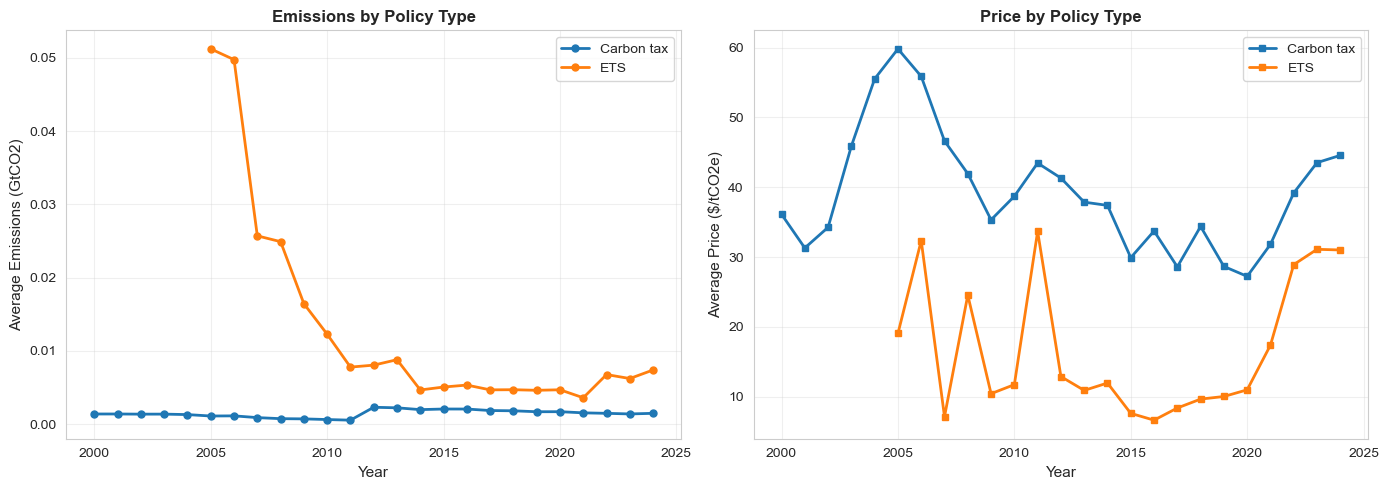

In [173]:
print("\n4. Carbon Tax vs ETS Comparison")

tax_data = df[df['Instrument Type'] == 'Carbon tax']
ets_data = df[df['Instrument Type'] == 'ETS']

print(f"\nCarbon Tax Policies:")
print(f"  Number of jurisdictions: {tax_data['Name of the initiative'].nunique()}")
print(f"  Observations: {len(tax_data)}")
print(f"  Mean price: ${tax_data['Price'].mean():.2f}/tCO2e")
print(f"  Mean emissions: {tax_data['Emissions'].mean():.6f} GtCO2")

print(f"\nETS Policies:")
print(f"  Number of jurisdictions: {ets_data['Name of the initiative'].nunique()}")
print(f"  Observations: {len(ets_data)}")
print(f"  Mean price: ${ets_data['Price'].mean():.2f}/tCO2e")
print(f"  Mean emissions: {ets_data['Emissions'].mean():.6f} GtCO2")

t_stat_type, p_val_type = stats.ttest_ind(tax_data['Emissions'], ets_data['Emissions'])
print(f"\nT-test (Tax vs ETS):")
print(f"  t-statistic: {t_stat_type:.4f}")
print(f"  p-value: {p_val_type:.6f}")

if p_val_type < 0.05:
    print(f"  Significant difference found between policy types")
else:
    print(f"  No significant difference between policy types")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

for ptype in df['Instrument Type'].unique():
    data = df[df['Instrument Type'] == ptype].groupby('Year')['Emissions'].mean()
    ax1.plot(data.index, data.values, 'o-', linewidth=2, label=ptype, markersize=5)
ax1.set_xlabel('Year', fontsize=11)
ax1.set_ylabel('Average Emissions (GtCO2)', fontsize=11)
ax1.set_title('Emissions by Policy Type', fontweight='bold', fontsize=12)
ax1.legend(fontsize=10)
ax1.grid(alpha=0.3)

for ptype in df['Instrument Type'].unique():
    data = df[df['Instrument Type'] == ptype].groupby('Year')['Price'].mean()
    ax2.plot(data.index, data.values, 's-', linewidth=2, label=ptype, markersize=5)
ax2.set_xlabel('Year', fontsize=11)
ax2.set_ylabel('Average Price ($/tCO2e)', fontsize=11)
ax2.set_title('Price by Policy Type', fontweight='bold', fontsize=12)
ax2.legend(fontsize=10)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [174]:
print("Summary")

summary = pd.DataFrame({
    'Metric': [
        'Sample Size',
        'Number of Jurisdictions',
        'Time Period',
        'Correlation (Price-Emissions)',
        'Elasticity (from regression)',
        'R-squared',
        'P-value (regression)',
        'High-Price Mean Emissions',
        'Low-Price Mean Emissions',
        'Difference Significant?',
        'Carbon Tax Mean Emissions',
        'ETS Mean Emissions',
        'Policy Type Difference Significant?'
    ],
    'Value': [
        len(df),
        df['Name of the initiative'].nunique(),
        f"{df['Year'].min()}-{df['Year'].max()}",
        f"{correlation:.4f}",
        f"{slope:.4f}",
        f"{r_val**2:.4f}",
        f"{p_val:.6f}",
        f"{high['Emissions'].mean():.6f}",
        f"{low['Emissions'].mean():.6f}",
        'Yes' if p_value < 0.05 else 'No',
        f"{tax_data['Emissions'].mean():.6f}",
        f"{ets_data['Emissions'].mean():.6f}",
        'Yes' if p_val_type < 0.05 else 'No'
    ]
})

print("\n" + summary.to_string(index=False))

Summary

                             Metric     Value
                        Sample Size       640
            Number of Jurisdictions        72
                        Time Period 2000-2024
      Correlation (Price-Emissions)   -0.1193
       Elasticity (from regression)   -0.3354
                          R-squared    0.0789
               P-value (regression)  0.000000
          High-Price Mean Emissions  0.002269
           Low-Price Mean Emissions  0.004779
            Difference Significant?       Yes
          Carbon Tax Mean Emissions  0.001572
                 ETS Mean Emissions  0.006610
Policy Type Difference Significant?       Yes


# Discussion

## What I Found

Looking at 640 observations from 72 jurisdictions (2000-2024), I found evidence that carbon prices are associated with lower emissions:

**The Price-Emissions Relationship:** The regression showed an elasticity of -0.3354 (p < 0.000001), meaning a 10% increase in carbon price is associated with a 3.35% decrease in emissions. However, the R² was only 0.0789, carbon price alone explains just 7.9% of emissions variation.

**High vs Low Prices:** High-price jurisdictions (>$17.05/tCO2e) had mean emissions of 0.00227 GtCO2 versus 0.00478 GtCO2 for low-price jurisdictions (p = 0.003). High-price areas show roughly half the emissions.

**Carbon Taxes vs ETS:** Carbon tax jurisdictions had lower emissions (0.00157 vs 0.00661 GtCO2, p < 0.000001), but they also had higher prices ($36.62 vs $18.29 /ton), suggesting price level matters more than policy type.

## Does This Support My Hypothesis?

Yes, with some caveats. All results consistently show higher prices associated with lower emissions, and the relationship is statistically significant. However:

- **Correlation isn't causation:** Low-emission countries may find it easier to implement high prices
- **Other policies matter:** Countries with carbon pricing typically have many other climate policies I can't account for
- **Time lags:** Many policies are recent (median: 9 years of data), and full effects take decades to materialize
- **Selection bias:** Countries adopting carbon pricing may already be on lower-emission paths

## What This Means

Carbon pricing shows a measurable association with lower emissions, but it explains less than 8% of emissions variation. GDP, industrial structure, energy resources, and other policies play major roles.

For policymakers, this means carbon pricing should be part of a broader climate strategy, set at meaningful levels (above the current $17/ton median), and complemented by other policies.

## What Could Be Done Better

Future research should:
- Include control variables (GDP, energy mix, industrial composition)
- Use panel regression or difference-in-differences methods to better isolate causal effects
- Analyze specific sectors separately
- Wait for more years of post-implementation data
- Examine emissions intensity rather than absolute emissions

## Conclusion

Carbon pricing shows a statistically significant negative relationship with emissions (elasticity: -0.335), but explains only 8% of variation. The evidence suggests carbon pricing probably helps reduce emissions, but it's not sufficient alone as it needs to be part of a comprehensive climate strategy with meaningful price levels maintained over time.